In [73]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, mean_squared_error
import random, os
from lightgbm import LGBMClassifier, LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
import optuna
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
SEED = 25
seed_everything(SEED) 

In [58]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

train.drop(columns=["PRODUCT_ID", "TIMESTAMP", 'LINE', 'PRODUCT_CODE'], inplace=True)
test.drop(columns=["PRODUCT_ID", "TIMESTAMP", 'LINE', 'PRODUCT_CODE'], inplace=True)
y = train['Y_Quality']

num_features = test.select_dtypes(exclude=['object']).columns.to_list()


#for col in num_features:
#    train[col] = train[col].fillna(train[col].median())

scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

X = train.drop(columns=['Y_Class', 'Y_Quality'])
X_test = test

from math import *
corr = pd.read_csv('correlation/correlation.csv')
# Y_Quality 제거
corr = corr.iloc[:-1,:]
important = list(corr[abs(corr['correlation'])>=0.1]['feature'])
#important
X = X[important]
X_test = X_test[important]

#dup = ~X.T.duplicated()
#X = X.loc[:, dup]
#X_test = X_test.loc[:, dup]

X_columns = X.columns
#num_features = X_test.select_dtypes(exclude=['object']).columns.to_list()
#scaler = StandardScaler()
#X[num_features] = scaler.fit_transform(X[num_features])
#X_test[num_features] = scaler.transform(X_test[num_features])
imputer = KNNImputer()
X = imputer.fit_transform(X)
X_test = imputer.transform(X_test)

In [59]:
X

array([[-2.06024776e-01, -2.03285896e-01, -5.46848299e-02, ...,
         7.07106781e-01,  7.07106781e-01,  1.04988860e+00],
       [ 4.39836611e-01,  4.09572321e-01,  2.27488892e-01, ...,
         2.82842712e-01,  2.82842712e-01,  2.67163142e-01],
       [ 4.07543542e-01,  3.77316626e-01,  2.27488892e-01, ...,
        -1.41421356e-01, -1.41421356e-01, -7.50558659e-02],
       ...,
       [-3.99783192e-01, -3.96820070e-01, -3.36858552e-01, ...,
        -1.41421356e+00, -1.41421356e+00, -1.33581571e+00],
       [-1.40593824e-14,  8.87834164e-15,  2.40978641e-15, ...,
        -1.48029737e-16, -1.48029737e-16,  0.00000000e+00],
       [-1.40593824e-14,  8.87834164e-15,  2.40978641e-15, ...,
        -1.48029737e-16, -1.48029737e-16,  0.00000000e+00]])

In [ ]:
def objective(trial):
  params = {
    'num_leaves': trial.suggest_int('num_leaves', 8, 20, step=1, log=True), 
    'max_depth': trial.suggest_int('max_depth', 3, 20, step=1, log=True), 
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True), 
    'n_estimators': trial.suggest_int('n_estimators', 50, 150, step=1, log=True), 
    "metric": "multiclass",
    'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
    'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
    'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
    'random_state': SEED
  }

  kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
  scores = []
  for train_index, test_index in kf.split(X, y):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y.values[train_index], y.values[test_index]
    model = LGBMClassifier(verbose=-1, **params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    pred = model.predict(X_valid)
    f1 = f1_score(y_valid, pred, average='macro')
    scores.append(f1)

  return np.mean(scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10000)

In [ ]:
study.best_trial

In [30]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [74]:
kf = KFold(n_splits=10, shuffle=True, random_state=25)

clfs = []
scores = []
for train_index, test_index in kf.split(X):
    #print(train_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y.values[train_index], y.values[test_index]
    
    #params = study.best_params
    params = {'num_leaves': 17,
        'max_depth': 11,
        'learning_rate': 0.07028290319049474,
       'n_estimators': 78,
        'class_weight': 'balanced',
        'min_child_samples': 12,
        'subsample': 0.831632859850219,
        'colsample_bytree': 0.9362544923583181,
        'reg_alpha': 0.01941513921336218,
        'reg_lambda': 0.0021722692515700652}
    
    #model = LGBMClassifier(random_state=SEED, verbose=-1, **params)
    model = LGBMRegressor(n_estimators = 2000, 
                        learning_rate = 0.01,
                        max_depth = 16,
                        min_child_samples = 56,
                        subsample = 0.4,
                        num_leaves = 160,
                        random_state = 42,
                        verbose=-1,
                        n_jobs = 8)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    pred = model.predict(X_valid)
    #f1 = f1_score(y_valid, pred, average='macro')
    score = mean_squared_error(y_valid, pred) ** 0.5
    scores.append(score)
    clfs.append(model)
print('Mean F1:', np.mean(scores))
#0.682161892591053
#0.6901148288419674

Mean F1: 0.005825849158678142


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
def display_importances(feature_importance_df_, doWorst=False, n_feat=50):
    # Plot feature importances
    if not doWorst:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index        
    else:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[-n_feat:].index
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    print('The list of features with 0 importance: ')
    print(df_2_neglect.index.values.tolist())
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')

In [80]:
import shap
def print_plot(fold):
    train = pd.read_csv('dataset/train.csv')

    train.drop(columns=["PRODUCT_ID", "TIMESTAMP", 'LINE', 'PRODUCT_CODE'], inplace=True)
    y = train['Y_Class']
    kf = KFold(n_splits=10, shuffle=True, random_state=25)

    clfs = []
    scores = []
    idx = 0
    for train_index, test_index in kf.split(X):
        idx += 1
        if fold == idx:
            
            importance_df = pd.DataFrame()
            #print(train_index)
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y.values[train_index], y.values[test_index]
            params = {'num_leaves': 17,
            'max_depth': 11,
            'learning_rate': 0.07028290319049474,
            'n_estimators': 78,
            'class_weight': 'balanced',
            'min_child_samples': 12,
            'subsample': 0.831632859850219,
            'colsample_bytree': 0.9362544923583181,
            'reg_alpha': 0.01941513921336218,
            'reg_lambda': 0.0021722692515700652}
    
            model = LGBMClassifier(random_state=SEED, verbose=-1, **params)
            #model = LGBMRegressor(n_estimators = 2000, 
            #                        learning_rate = 0.01,
            #                        max_depth = 16,
            #                        min_child_samples = 56,
            #                        subsample = 0.4,
            #                        num_leaves = 160,
            #                        random_state = 42,
            #                        verbose=-1,
            #                        n_jobs = 8)

            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
                
            importance_df["feature"] = X_columns.tolist()      
            importance_df["importance"] = model.booster_.feature_importance('gain')
            #display_importances(feature_importance_df_=importance_df, n_feat=50)
            shap_values = shap.TreeExplainer(model.booster_).shap_values(X_train)
            shap.summary_plot(shap_values, X, plot_type='bar')
        

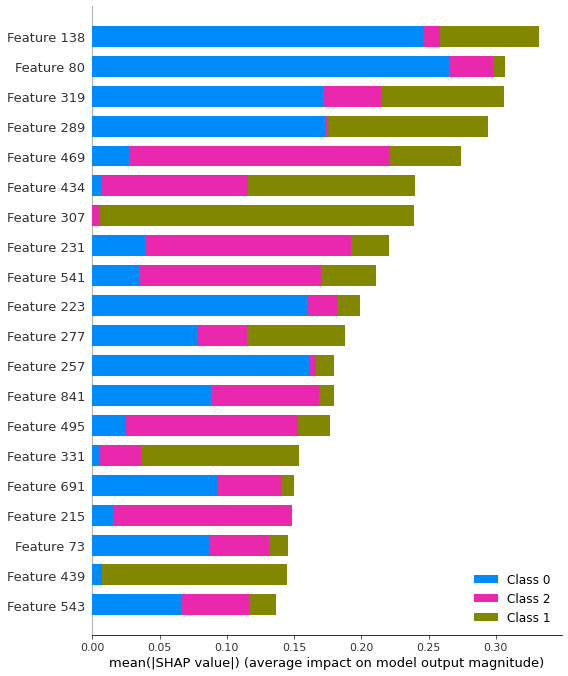

In [81]:
print_plot(1)

In [ ]:
preds = []
for i, model in enumerate(clfs):
    pred = model.predict_proba(X_test)
    if i == 0:
        preds = pred
    else:
        preds += pred
print(preds)
final_pred = np.argmax(preds, axis=1)

submit = pd.read_csv('sample_submission.csv')
submit['Y_Class'] = final_pred
submit.to_csv('submission.csv', index=False)
final_pred